In [1]:
# cereals_forecast.py
# ----------------------------------------
# Previsão da Produção de Cereais em Angola
# Dataset: FAOSTAT (Produção de Cereais, Angola)
# ----------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pathlib import Path


Matplotlib is building the font cache; this may take a moment.


In [2]:
# -------------------------------
# Função para calcular MAPE
# -------------------------------
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    eps = 1e-9  # evitar divisão por zero
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100

# -------------------------------
# Carregar os dados
# -------------------------------
file_path = "FAOSTAT_data_en_9-5-2025.csv"  # <-- ajuste o caminho do CSV
raw = pd.read_csv(file_path)



In [3]:
# Filtrar apenas Produção de Cereais em Angola
df = (
    raw[(raw["Area"] == "Angola") &
        (raw["Item"] == "Cereals, primary") &
        (raw["Element"] == "Production")]
    .loc[:, ["Year", "Value"]]
    .dropna()
    .sort_values("Year")
)



In [4]:
df.head(10)

,Year,Value
2,1961,544000.0
5,1962,543000.0
8,1963,515000.0
11,1964,564000.0
14,1965,562000.0
17,1966,502000.0
20,1967,515000.0
23,1968,526148.0
26,1969,648090.0
29,1970,575915.0


In [5]:
df = df.iloc[41:]

In [6]:
df.head(20)

,Year,Value
125,2002,733819.00
128,2003,736542.08
131,2004,742341.31
134,2005,914886.00
137,2006,723305.00
140,2007,780963.00
143,2008,754711.00
146,2009,1056844.00
149,2010,1181944.00
152,2011,1412826.00


In [7]:
# Garantir numérico
df["Value"] = pd.to_numeric(df["Value"], errors="coerce")
df = df.dropna(subset=["Value"])



In [8]:
# Criar série temporal
ts = df.set_index(pd.PeriodIndex(df["Year"].astype(int), freq="Y"))["Value"].astype(float)
ts.index = ts.index.to_timestamp()  # DatetimeIndex no fim de cada ano



In [9]:
# -------------------------------
# Dividir treino e teste
# -------------------------------
n_obs = len(ts)
test_years = 10 if n_obs >= 25 else max(5, n_obs // 4)
train = ts.iloc[:-test_years]
test = ts.iloc[-test_years:]

results = []



In [10]:
# -------------------------------
# Modelo 1: Holt-Winters (ETS)
# -------------------------------
try:
    ets = ExponentialSmoothing(
        train,
        trend="add",
        damped_trend=True,
        seasonal=None,
        initialization_method="estimated",
    ).fit(optimized=True)
    ets_fc = ets.forecast(len(test))
    ets_mape = mape(test, ets_fc)
    results.append(("ETS_add_damped", ets_mape, ets, ets_fc))
except Exception as e:
    print("Erro ETS:", e)



/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [11]:
# -------------------------------
# Modelo 2: ARIMA(1,1,1)
# -------------------------------
try:
    arima = SARIMAX(train, order=(1,1,1), trend="c",
                    enforce_stationarity=False,
                    enforce_invertibility=False).fit(disp=False)
    arima_fc = arima.get_forecast(len(test)).predicted_mean
    arima_mape = mape(test, arima_fc)
    results.append(("ARIMA(1,1,1)+c", arima_mape, arima, arima_fc))
except Exception as e:
    print("Erro ARIMA:", e)



In [12]:
# -------------------------------
# Selecionar melhor modelo
# -------------------------------
if results:
    results.sort(key=lambda x: x[1])
    best_name, best_mape, best_model, best_fc = results[0]
    print(f"Melhor modelo: {best_name} (MAPE={best_mape:.2f}%)")
else:
    raise RuntimeError("Nenhum modelo pôde ser ajustado.")



Melhor modelo: ARIMA(1,1,1)+c (MAPE=4.84%)


In [13]:
# -------------------------------
# Reajustar no dataset completo e prever 5 anos
# -------------------------------
h = 5
if "ETS" in best_name:
    final_model = ExponentialSmoothing(
        ts, trend="add", damped_trend=True,
        seasonal=None, initialization_method="estimated"
    ).fit(optimized=True)
    fc_index = pd.date_range(ts.index[-1] + pd.offsets.YearEnd(), periods=h, freq="Y")
    final_fc = pd.Series(final_model.forecast(h).values, index=fc_index, name="Forecast")
else:
    final_model = SARIMAX(ts, order=(1,1,1), trend="c",
                          enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    fc_res = final_model.get_forecast(h)
    fc_index = pd.date_range(ts.index[-1] + pd.offsets.YearEnd(), periods=h, freq="Y")
    final_fc = pd.Series(fc_res.predicted_mean.values, index=fc_index, name="Forecast")



<ipython-input-13-7226a96e5c74>:16: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  fc_index = pd.date_range(ts.index[-1] + pd.offsets.YearEnd(), periods=h, freq="Y")


In [14]:
# -------------------------------
# Exportar CSV
# -------------------------------
out = pd.DataFrame({"Year": [d.year for d in ts.index], "Production_tonnes": ts.values})
fc_out = pd.DataFrame({"Year": [d.year for d in final_fc.index], "Forecast_tonnes": final_fc.values})
export = out.merge(fc_out, how="outer", on="Year")
out_path = Path("cereals_production_forecast_2002+.csv")
export.to_csv(out_path, index=False)
print(f"Arquivo salvo em: {out_path.resolve()}")



Arquivo salvo em: /drive/FAOSTAT/cereals_production_forecast_2002+.csv


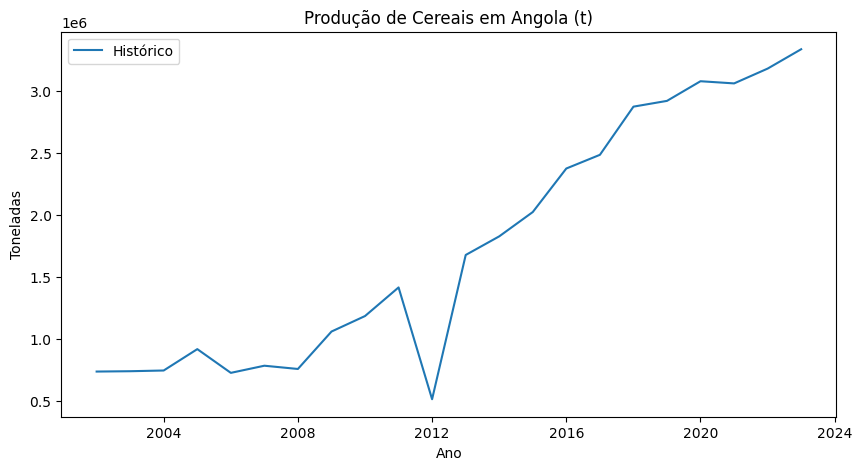

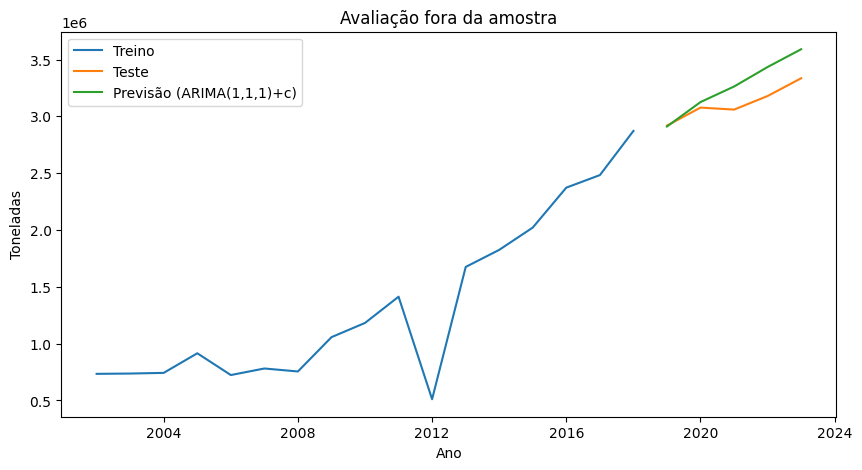

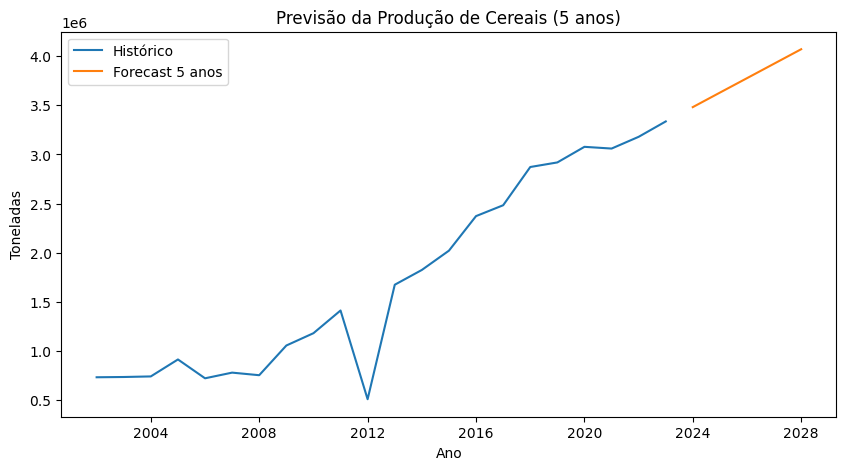

In [15]:
# -------------------------------
# Gráficos
# -------------------------------
plt.figure(figsize=(10, 5))
plt.plot(ts.index, ts.values, label="Histórico")
plt.title("Produção de Cereais em Angola (t)")
plt.xlabel("Ano")
plt.ylabel("Toneladas")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train.index, train.values, label="Treino")
plt.plot(test.index, test.values, label="Teste")
plt.plot(test.index, best_fc.values, label=f"Previsão ({best_name})")
plt.title("Avaliação fora da amostra")
plt.xlabel("Ano")
plt.ylabel("Toneladas")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(ts.index, ts.values, label="Histórico")
plt.plot(final_fc.index, final_fc.values, label="Forecast 5 anos")
plt.title("Previsão da Produção de Cereais (5 anos)")
plt.xlabel("Ano")
plt.ylabel("Toneladas")
plt.legend()
plt.show()